In [90]:
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [91]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# img, label = train_dataset[0], train_dataset[1]
img, label = X_train, y_train

c:\Users\18raj\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


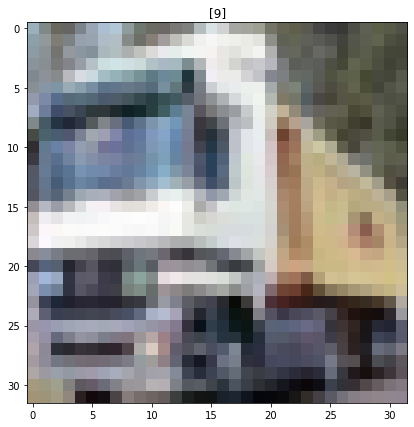

In [92]:
plt.figure(figsize=(10, 7))
plt.imshow(img[1])
plt.title(label[1])
plt.show()

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (40000, 1) (10000, 1)


In [94]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.length = len(X)
        self.X = X
        self.y = y
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        X = self.X[idx]
        # y = torch.zeros(10)
        # y[self.y[idx][0]] = 1
        y = self.y[idx].squeeze()
        X_tensor = torch.from_numpy(X).to(torch.float32).permute(2, 0, 1)
        y_tensor = torch.tensor(y).to(torch.long)
        return X_tensor, y_tensor

In [95]:
train_data = MyDataset(X_train, y_train)
val_data = MyDataset(X_val, y_val)
test_data = MyDataset(X_test, y_test)

In [96]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [97]:
next(iter(train_dataloader))

[tensor([[[[ 70.,  75.,  80.,  ...,  86.,  82.,  78.],
           [ 74.,  79.,  83.,  ...,  91.,  88.,  85.],
           [ 85.,  87.,  89.,  ..., 101.,  98.,  94.],
           ...,
           [118., 133., 139.,  ..., 117., 114.,  99.],
           [121., 135., 136.,  ..., 107., 111., 109.],
           [130., 132., 145.,  ..., 111., 108., 107.]],
 
          [[120., 124., 127.,  ..., 132., 130., 126.],
           [124., 128., 131.,  ..., 138., 134., 131.],
           [132., 133., 136.,  ..., 147., 142., 137.],
           ...,
           [102., 115., 119.,  ..., 101.,  97.,  84.],
           [106., 116., 113.,  ...,  93.,  97.,  96.],
           [114., 112., 123.,  ...,  99.,  95.,  93.]],
 
          [[205., 210., 215.,  ..., 219., 216., 212.],
           [208., 214., 219.,  ..., 224., 220., 217.],
           [216., 220., 224.,  ..., 231., 226., 222.],
           ...,
           [ 66.,  80.,  88.,  ...,  71.,  68.,  56.],
           [ 72.,  83.,  83.,  ...,  63.,  69.,  69.],
           

In [122]:
class Cifar(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, shape):
        super(Cifar, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*shape*shape, out_features=output_size)
        )
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [123]:
model = Cifar(input_size=3, hidden_units=10, output_size=10, shape=5)
model

Cifar(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=250, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

In [124]:
def train(model: nn.Module,
        loss_fn: nn.Module,
        optimizer: torch.optim.Optimizer,
        dataloader: torch.utils.data.DataLoader,
        device="cpu"
    ):
    model.train()
    train_loss, accuracy = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        accuracy += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss/len(dataloader)
    accuracy = accuracy/len(dataloader)
    return train_loss, accuracy

In [125]:
def test(model: nn.Module,
        loss_fn: nn.Module,
        dataloader: torch.utils.data.DataLoader,
        device="cpu"
    ):
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            accuracy += (y_pred_class == y).sum().item()/len(y_pred)
    test_loss = test_loss/len(dataloader)
    accuracy = accuracy/len(dataloader)
    return test_loss, accuracy

In [126]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [127]:
results = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test(model=model,
                                    dataloader=val_dataloader,
                                    loss_fn=loss_fn)
    
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_accuracy"].append(test_acc)

torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
torch.Size([32, 10, 5, 5])
t

KeyboardInterrupt: 